<a href="https://colab.research.google.com/github/XRayrahman/redrone/blob/main/train_drone.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [275]:
import os

import numpy as np
import matplotlib.pyplot as plt

import tensorflow as tf
from tensorflow import keras
from keras.optimizers import SGD, RMSprop, Adam

In [310]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator
dataset_dir = ('/content/images')
print(dataset_dir)

# from zipfile import ZipFile
# file_name = dataset_dir

# with ZipFile(file_name, 'r') as zip:
#   zip.extractall()
#   print('Done')

/content/images


In [313]:
image_size = (24, 32)

# Image generator batch size
batch_size = 100


# Instantiate a generator that puts 30% of the images into the validation set
# and normalizes their pixel values between 0 and 1
generator = ImageDataGenerator(rescale=1./255, validation_split=0.25)

In [314]:
train_data = generator.flow_from_directory(dataset_dir,
                                           target_size=image_size,
                                           batch_size=batch_size,
                                           subset='training',
                                           class_mode='categorical',
                                           color_mode='rgb')

test_data = generator.flow_from_directory(dataset_dir,
                                          target_size=image_size,
                                          batch_size=batch_size,
                                          subset='validation',
                                          class_mode='categorical',
                                          color_mode='rgb')

Found 727 images belonging to 3 classes.
Found 240 images belonging to 3 classes.


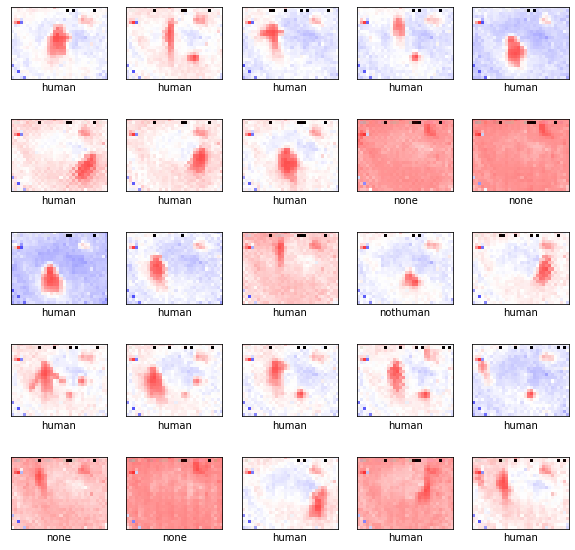

In [315]:
index_to_label = {
  index: label
  for label, index in train_data.class_indices.items()
}

plt.figure(figsize=(10, 10))
batch = train_data.next()

for i in range(min(25, len(batch[0]))):
  img = batch[0][i]

  label = index_to_label[np.argmax(batch[1][i])]
  plt.subplot(5, 5, i+1)
  plt.xticks([])
  plt.yticks([])
  plt.grid(False)

  # Note the np.squeeze call - matplotlib can't
  # process grayscale images unless the extra
  # 1-sized dimension is removed.
  plt.imshow(np.squeeze(img))
  plt.xlabel(label)

plt.show()

In [316]:
data_augmentation = keras.Sequential(
  [
    keras.layers.RandomFlip("horizontal",
                      input_shape=(24,
                                  32,
                                  3)),
    keras.layers.RandomRotation(0.1),
    keras.layers.RandomZoom(0.1),
  ]
)

In [317]:
model = keras.Sequential(
    [
    data_augmentation,
    keras.layers.Conv2D(32, (3,3), padding='same', activation="relu",input_shape=(24, 32,3)),
    keras.layers.MaxPooling2D((2, 2), strides=2),

    keras.layers.Conv2D(64, (3,3), padding='same', activation="relu"),
    keras.layers.MaxPooling2D((2, 2), strides=2),
    keras.layers.Conv2D(64, (3,3), padding='same', activation="relu"),
    keras.layers.MaxPooling2D((2, 2), strides=1),
    # keras.layers.LeakyReLU(alpha=0.2)
    keras.layers.Flatten(),
    keras.layers.Dropout(rate=.5),
    keras.layers.Dense(64, kernel_regularizer=keras.regularizers.l2(0.001),
    activation=tf.nn.relu),
    # Layer 2: fully-connected layer with 30% the neurons as the input images
    # and RELU activation function
    keras.layers.Dense(32, kernel_regularizer=keras.regularizers.l2(0.001),
    activation=tf.nn.relu),
     
    # Layer 3: fully-connected layer with as many units as the output labels
    # and Softmax activation function
    keras.layers.Dense(len(train_data.class_indices),
                      activation=tf.nn.softmax)
    ]
)

In [318]:

# Number of training epochs
epochs = 100
# Compile the model for classification, use the Adam optimizer and pick
# accuracy as optimization metric
model.compile(loss='categorical_crossentropy',
              optimizer=Adam(learning_rate=0.001),
              metrics=['accuracy'])

# Train the model in batches
history = model.fit(
  train_data,
  steps_per_epoch=train_data.samples/batch_size,
  validation_data=test_data,
  validation_steps=test_data.samples/batch_size,
  epochs=epochs
)

Epoch 1/100
7/7 [==============================] - 5s 560ms/step - loss: 0.8606 - accuracy: 0.7813 - val_loss: 0.7380 - val_accuracy: 0.8000
Epoch 2/100
7/7 [==============================] - 3s 395ms/step - loss: 0.7066 - accuracy: 0.7964 - val_loss: 0.6243 - val_accuracy: 0.8000
Epoch 3/100
7/7 [==============================] - 4s 519ms/step - loss: 0.5673 - accuracy: 0.8514 - val_loss: 0.4802 - val_accuracy: 0.9125
Epoch 4/100
7/7 [==============================] - 3s 386ms/step - loss: 0.4526 - accuracy: 0.9202 - val_loss: 0.5987 - val_accuracy: 0.8375
Epoch 5/100
7/7 [==============================] - 3s 389ms/step - loss: 0.4422 - accuracy: 0.9037 - val_loss: 0.4162 - val_accuracy: 0.9125
Epoch 6/100
7/7 [==============================] - 3s 390ms/step - loss: 0.3885 - accuracy: 0.9188 - val_loss: 0.4078 - val_accuracy: 0.9208
Epoch 7/100
7/7 [==============================] - 3s 391ms/step - loss: 0.3757 - accuracy: 0.9202 - val_loss: 0.4418 - val_accuracy: 0.9083
Epoch 8/100
7

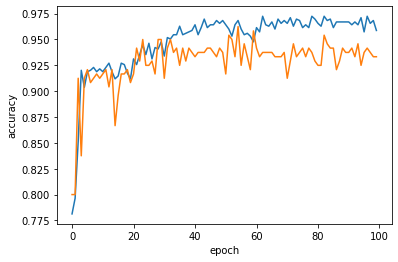

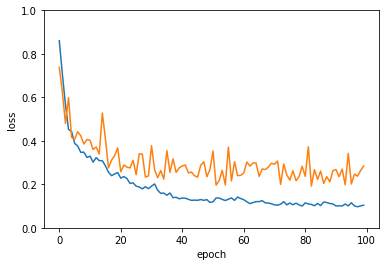

In [337]:
epochs = history.epoch
accuracy = history.history['accuracy']
val_acc = history.history['val_accuracy']
fig = plt.figure()
plot = fig.add_subplot()
plot.set_xlabel('epoch')
plot.set_ylabel('accuracy')
# plot.set_ylim([.7,1])
plot.plot(epochs, accuracy)
plot.plot(epochs, val_acc)

loss = history.history['loss']
val_loss = history.history['val_loss']
fig2 = plt.figure()
plot2 = fig2.add_subplot()
plot2.set_xlabel('epoch')
plot2.set_ylabel('loss')
plot2.set_ylim([0,1])
plot2.plot(epochs, loss)
plot2.plot(epochs, val_loss)

In [320]:
model.summary()

Model: "sequential_62"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential_61 (Sequential)  (None, 24, 32, 3)         0         
                                                                 
 conv2d_154 (Conv2D)         (None, 24, 32, 32)        896       
                                                                 
 max_pooling2d_125 (MaxPooli  (None, 12, 16, 32)       0         
 ng2D)                                                           
                                                                 
 conv2d_155 (Conv2D)         (None, 12, 16, 64)        18496     
                                                                 
 max_pooling2d_126 (MaxPooli  (None, 6, 8, 64)         0         
 ng2D)                                                           
                                                                 
 conv2d_156 (Conv2D)         (None, 6, 8, 64)        

In [321]:
y_true=240
y_pred=model.predict(test_data)
print(y_pred)

3/3 [==============================] - 1s 117ms/step
[[9.99787569e-01 1.81563752e-04 3.09677744e-05]
 [9.99999821e-01 6.25480965e-08 9.10528814e-13]
 [9.99992907e-01 5.52952270e-06 1.52006055e-06]
 [9.99999821e-01 9.10114650e-08 7.20322413e-12]
 [9.99987543e-01 6.42440727e-06 5.94162793e-06]
 [9.99999702e-01 1.99864715e-07 1.91881070e-13]
 [9.99999583e-01 4.10015929e-07 6.75090955e-11]
 [9.26444411e-01 1.26892990e-02 6.08662255e-02]
 [9.88689184e-01 1.13107292e-02 2.35859581e-08]
 [9.99984801e-01 9.30240731e-06 5.83667907e-06]
 [1.30062559e-04 9.99867916e-01 2.07119729e-06]
 [9.98177469e-01 1.52890256e-03 2.93559744e-04]
 [9.99838591e-01 1.61400763e-04 4.56818441e-08]
 [7.51474857e-01 5.80388047e-02 1.90486282e-01]
 [9.99994099e-01 5.84119925e-06 1.26124950e-08]
 [9.99992907e-01 7.08526113e-06 1.48026225e-09]
 [9.99999464e-01 4.81155269e-07 1.27198641e-10]
 [9.99999940e-01 1.78152284e-08 4.69772333e-13]
 [9.99999821e-01 1.13750104e-07 1.66767850e-11]
 [9.99998629e-01 1.29927184e-06 2.4

In [ ]:
from sklearn.metrics import plot_confusion_matrix

In [322]:
class estimator:
  _estimator_type = ''
  classes_=[]
  def __init__(self, model, classes):
    self.model = model
    self._estimator_type = 'classifier'
    self.classes_ = classes
  def predict(self, X):
    y_prob= self.model.predict(X)
    y_pred = y_prob.argmax(axis=1)
    return y_pred

classifier = estimator(model, test_data.classes)
print(test_data.classes)

[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 2 2 2 2 2 2 2 2 2 2 2 2 2]


/usr/local/lib/python3.8/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


3/3 [==============================] - 0s 119ms/step


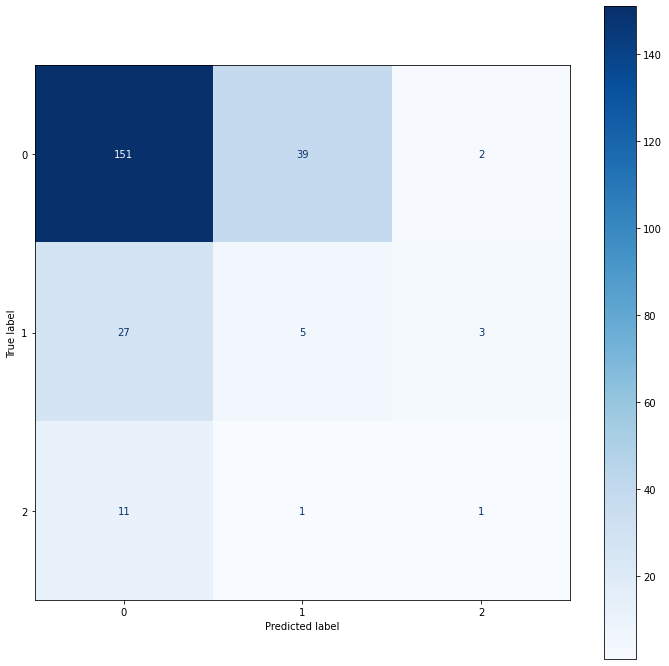

In [332]:
figsize = (12,12)
plot_confusion_matrix(estimator=classifier, X=test_data, y_true=test_data.classes, cmap='Blues', normalize=None,  ax=plt.subplots(figsize=figsize)[1])

/usr/local/lib/python3.8/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


2/2 [==============================] - 0s 9ms/step


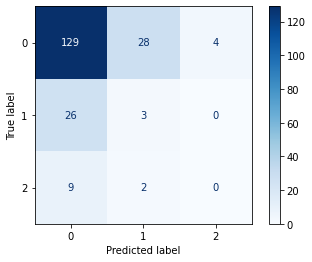

In [ ]:
plot_confusion_matrix(estimator=classifier, X=test_data, y_true=test_data.classes, cmap='Blues')